In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from gensim.models import Word2Vec
from sklearn.manifold import TSNE 
from IPython.core.debugger import set_trace
from sklearn import cluster

Using TensorFlow backend.


In [2]:
response_df = pd.read_csv('correct.tsv', sep='\t').drop('Unnamed: 0', axis=1)
skill_df = pd.read_csv('skill.tsv', sep='\t').drop('Unnamed: 0', axis=1)
assistment_df = pd.read_csv('assistment_id.tsv', sep='\t').drop('Unnamed: 0', axis=1)
skill_dict = {}
with open('skill_dict.json', 'r', encoding='utf-8') as f:
    loaded = json.load(f)
    for k, v in loaded.items():
        skill_dict[k] = int(v)

skill_num = len(skill_dict) + 1 # including 0
#skill_num=len(np.unique(skill_df.iloc[:,2:51]))
#Need to deal with having unequal number of problems for each student. Is this allowable in DKT?
skill_df100=skill_df[skill_df.num_resp>100].copy()
assistment_df100=assistment_df[assistment_df.num_resp>100].copy()
response_df100=response_df[response_df.num_resp>100].copy()

In [3]:
#Create assistment encoding
assistment_re_df100=assistment_df100.copy()
assistment_enc_mat=assistment_df100.iloc[:,2:103].values.astype(int)
assistment_enc=np.reshape(assistment_enc_mat,assistment_enc_mat.shape[0]*assistment_enc_mat.shape[1])
assistment_enc2=np.unique(assistment_enc)

num_assist=len(assistment_enc2)
assistment_label=np.arange(num_assist)
for ii in range(num_assist):
    assistment_enc_mat[assistment_enc_mat==assistment_enc2[ii]]=ii
    
    
#for ii in range(assistment_enc_mat.shape[0]):
#    for jj in range(assistment_enc_mat.shape[1]):
#        temp=assistment_enc_mat[ii,jj]
#        assistment_enc_mat[ii,jj]=assistment_label[assistment_enc2==temp]
        
assistment_re_df100.iloc[:,2:103]=assistment_enc_mat

0

In [70]:
temp=assistment_enc_mat==assistment_enc2[ii]

In [82]:
ii

0

In [72]:
assistment_enc_mat.shape

(584, 101)

In [4]:
def one_hot(skill_matrix, vocab_size):
    '''
    params:
        skill_matrix: 2-D matrix (student, skills)
        vocal_size: size of the vocabulary
    returns:
        a ndarray with a shape like (student, sequence_len, vocab_size)
    '''
    seq_len = skill_matrix.shape[1] #Number of exercises (sequence length)
    #Initialize result (student, sequence, one-hot skill) to zeros
    result = np.zeros((skill_matrix.shape[0], seq_len, vocab_size)) 
    #For each student
    for i in range(skill_matrix.shape[0]):
        #Select the student, all sequences, and the related skill; set to 1
        result[i, np.arange(seq_len), skill_matrix[i]] = 1.
    return result

def dkt_one_hot(skill_matrix, response_matrix, vocab_size):
    #Number of exercises/skills
    seq_len = skill_matrix.shape[1]
    #Initialize output (student, sequence, 2 * vocab size) to zeros
    skill_response_array = np.zeros((skill_matrix.shape[0], seq_len, 2 * vocab_size))
    #For each student
    for i in range(skill_matrix.shape[0]):
        #Set to 1 the (student, all sequences, skill location + [0 1] if correct and + [1 0] if incorrect)
        skill_response_array[i, np.arange(seq_len), 2 * skill_matrix[i] + response_matrix[i]] = 1.
    return skill_response_array


#Function to preprocess the data
def preprocess(skill_df, response_df, skill_num):
    skill_matrix = skill_df.iloc[:, 2:].values.astype(int) #Select values (excluding first column, which is index)
    response_array = response_df.iloc[:, 2:].values.astype(int)
    #Get the one-hots associated with each (student, sequence, skill one-hot)
    skill_array = one_hot(skill_matrix, skill_num)
    #Get the one-hots associated with (student, sequence, response one-hot)
    #and (student, sequence, skill one-hot)
    #skill_response_array, masking_array = dkt_one_hot(skill_matrix, response_array, skill_num)
    skill_response_array = dkt_one_hot(skill_matrix, response_array, skill_num)
    return skill_array, response_array, skill_response_array
    

assist_array, response_array, assist_response_array = preprocess(assistment_re_df100.iloc[:,0:103], response_df100.iloc[:,0:103], num_assist)

In [5]:
import keras
from keras.layers import Input, Dense, LSTM, TimeDistributed, Lambda, multiply
from keras.models import Model
from keras.optimizers import RMSprop, Adam
from keras.preprocessing.sequence import pad_sequences
from keras import backend as K
from keras.callbacks import EarlyStopping

#Function to set up skill to skill model (input skills, output skill prediction)
def build_skill2skill_model(input_shape, lstm_dim=32, dropout=0.0):
    input = Input(shape=input_shape, name='input_skills')
    lstm = LSTM(lstm_dim, 
                return_sequences=True, 
                dropout=dropout,
                name='lstm_layer')(input)
    output = TimeDistributed(Dense(input_shape[-1], activation='softmax'), name='probability')(lstm)
    model = Model(inputs=[input], outputs=[output])
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()
    return model

def reduce_dim(x):
    x = K.max(x, axis=-1, keepdims=True)
    return x

#Skill and response
def build_dkt_model(input_shape, lstm_dim=32, dropout=0.0):
    input_skills = Input(shape=input_shape, name='input_skills') #A, input, [skill(identified) correctness]
    #LSTM hidden layer, processing input_skills
    lstm = LSTM(lstm_dim, 
                return_sequences=True, 
                dropout=dropout,
                name='lstm_layer')(input_skills)
    
    #Output layer, acting on outputs of LSTM
    #Probability of each skill being correct upon the next question
    dense = TimeDistributed(Dense(int(input_shape[-1]/2), activation='sigmoid'), name='probability_for_each')(lstm)
 
    #b, input, [actual next skill (identified)]
    skill_next = Input(shape=(input_shape[0], int(input_shape[1]/2)), name='next_skill_tested')
    #Select the actual next skill's probability
    merged = multiply([dense, skill_next], name='multiply')
    #Get only that result --> this is the output
    reduced = Lambda(reduce_dim, output_shape=(input_shape[0], 1), name='reduce_dim')(merged)
    
    #Optimize using Adam
    model = Model(inputs=[input_skills, skill_next], outputs=[reduced])
    model2 = Model(inputs=[input_skills], outputs=[dense])
    
    adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, decay=0.0)
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=['accuracy'])
    model.summary()
    return model, model2

In [6]:
print('dkt')
dkt_model, dkt_model2 = build_dkt_model((100, 2 * num_assist), lstm_dim=64)

dkt_model.fit([assist_response_array[:, 0:-1], assist_array[:, 1:]],
              response_array[:, 1:, np.newaxis],
              epochs=20, 
              batch_size=32, 
              shuffle=True,
              validation_split=0.2)

dkt
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_skills (InputLayer)        (None, 100, 19066)    0                                            
____________________________________________________________________________________________________
lstm_layer (LSTM)                (None, 100, 64)       4897536     input_skills[0][0]               
____________________________________________________________________________________________________
probability_for_each (TimeDistri (None, 100, 9533)     619645      lstm_layer[0][0]                 
____________________________________________________________________________________________________
next_skill_tested (InputLayer)   (None, 100, 9533)     0                                            
_______________________________________________________________________________________

In [ ]:
#Associate assistment with skill

assistment_enc_mat2=assistment_df100.iloc[:,2:103].values.astype(int)
skill_enc_mat=skill_df100.iloc[:,2:103].values.astype(int)
skill_enc2=np.zeros(num_assist,dtype=int)

for ii in range(num_assist):
    skill_enc=skill_enc_mat[assistment_enc_mat2==assistment_enc2[ii]]
    set_trace()
    skill_enc2[ii]=skill_enc[0]
    

In [99]:
#Create input to generate influence matrix
#Input: each skill, correct
response_test=np.ones((1,num_assist)).astype('int')
assist_test=np.cumsum(response_test)-1
assist_test=assist_test.reshape((1,num_assist)).astype('int')

#Get the one-hots associated with each (student, sequence, skill one-hot)
assist_test_array = one_hot(assist_test, num_assist)
    #Get the one-hots associated with (student, sequence, response one-hot)
    #and (student, sequence, skill one-hot)
assist_response_test_array = dkt_one_hot(assist_test, response_test, num_assist)

In [100]:
q_matrix=np.zeros((num_assist,num_assist))
seq_len=100
for i in range(num_assist):
    assist_response_array2 = np.zeros((1,seq_len,2 * num_assist))
    assist_response_array2[0, np.arange(seq_len), 2 * i + 1] = 1.
    #set_trace()
    temp=dkt_model2.predict(assist_response_array2)
    q_matrix[i,:]=temp[0,0,:]

#q_matrix=q_matrix[0:-1,0:-1]

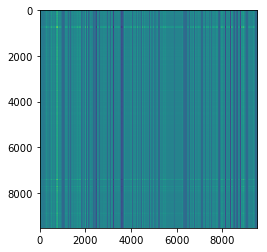

In [101]:
plt.imshow(q_matrix)

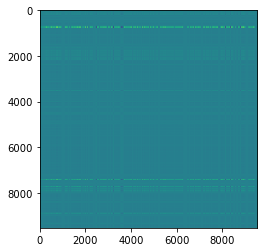

In [103]:
q_matrix_sum=np.sum(q_matrix,axis=0)
q_matrix_n=q_matrix/np.tile(q_matrix_sum,[num_assist, 1])
plt.imshow(q_matrix_n)
q_matrix_sym=np.add(q_matrix_n,q_matrix_n.transpose())/2

In [ ]:
import networkx as nx
G=nx.from_numpy_matrix(q_matrix_sym)
L1 = nx.linalg.laplacian_matrix(G)
L1_nd=L1.toarray()
S1 = nx.linalg.laplacian_spectrum(G)
eigVal,eigVec = np.linalg.eig(L1_nd)

In [ ]:
featureLen=50;
featureVec=eigVec[:,0:featureLen]

NCr = 64
sse = np.zeros(NCr)
for NC in range(NCr): # number of clusters for K-means
    kmeanse = cluster.KMeans(n_clusters=(NC+1)).fit(featureVec)
    labels = kmeanse.labels_
    centers = kmeanse.cluster_centers_
    for i in range(NC+1):
        sse[NC] += np.sum((featureVec[np.where(labels==i)]-centers[i])**2)
        
plt.plot(np.arange(NCr)+1,sse)

In [106]:
spectral = cluster.SpectralClustering(n_clusters=32,affinity='precomputed')
#temp=spectral.fit(q_matrix_n)#q_matrix_sym)#
temp2=spectral.fit(q_matrix_sym)#
#dkt_clusters=spectral.fit_predict(q_matrix_n)#q_matrix_n)
dkt_clusters2=spectral.fit_predict(q_matrix_sym)#q_matrix_n)

In [107]:
pd.Series(dkt_clusters2).value_counts()

24    334
13    332
11    329
3     323
31    321
6     318
21    318
5     318
1     318
28    315
19    307
18    306
29    304
9     302
15    302
12    301
10    298
23    296
25    295
22    293
14    293
0     291
17    290
27    288
20    286
8     286
26    281
4     280
16    270
30    254
2     249
7     235
dtype: int64

In [ ]:
assistment_enc_mat2=assistment_df100.iloc[:,2:103].values.astype(int)
skill_enc_mat=skill_df100.iloc[:,2:103].values.astype(int)

for ii in range(num_assist):
    skill_enc2=skill_enc_mat